In [ ]:
from tensorflow import keras
from keras.datasets import mnist
from keras.layers import *
from keras .models import Sequential,Model
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(xtrain,_),(_,_)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(xtrain.shape)

(60000, 28, 28)


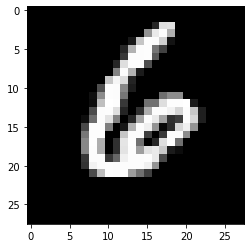

In [ ]:
plt.imshow(xtrain[13],cmap='gray')
plt.show()

In [ ]:
xtrain=(xtrain.astype('float32')-127.5)/127.5
print(np.min(xtrain))
print(np.max(xtrain))

-1.0
1.0


In [ ]:
TOTAL_EPOCHS=10
BATCH_SIZE=256
NO_OF_BATCHES=int(xtrain.shape[0]/BATCH_SIZE) 
HALF_BATCH=128
NOISE_DIM=100 # Upsample into 784 Dim Vector
adam=keras.optimizers.Adam(lr=2e-4,beta_1=0.5)

In [ ]:
generator=Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [ ]:
discriminator=Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer=adam)

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
discriminator.trainable=False
gan_input=Input(shape=(NOISE_DIM,))
generated_img=generator(gan_input)
gan_output=discriminator(generated_img)

In [ ]:
model=Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [ ]:
xtrain=xtrain.reshape(-1,784)
print(xtrain.shape)

(60000, 784)


In [ ]:
def save_imgs(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs=generator.predict(noise)
    generated_imgs=generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

Epoch 1 Disc Loss 0.6434 Generator Loss 1.0356
Epoch 2 Disc Loss 0.6439 Generator Loss 1.0445
Epoch 3 Disc Loss 0.6469 Generator Loss 1.0228
Epoch 4 Disc Loss 0.6484 Generator Loss 1.0268
Epoch 5 Disc Loss 0.6484 Generator Loss 1.0285


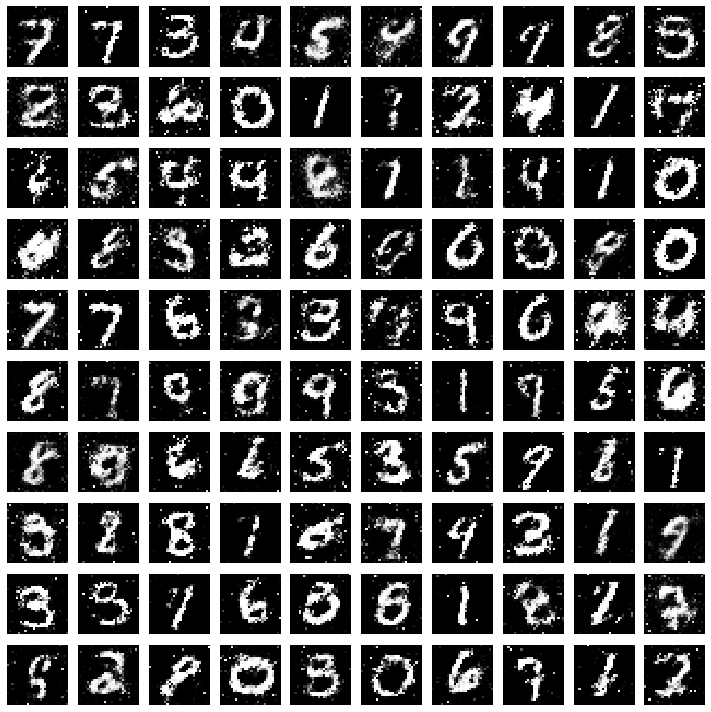

Epoch 6 Disc Loss 0.6522 Generator Loss 1.0266
Epoch 7 Disc Loss 0.6517 Generator Loss 1.0248
Epoch 8 Disc Loss 0.6541 Generator Loss 1.0137
Epoch 9 Disc Loss 0.6543 Generator Loss 1.0138
Epoch 10 Disc Loss 0.6561 Generator Loss 1.0194


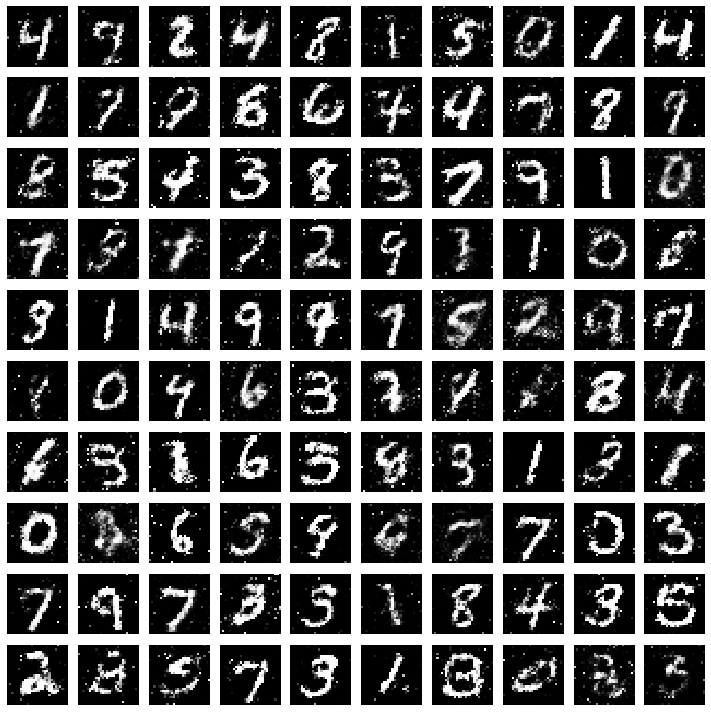

In [ ]:
d_losses=[]
g_losses=[]

for epoch in range(TOTAL_EPOCHS):
  epc_d_loss=0.
  epc_g_loss=0.
  for steps in range(NO_OF_BATCHES):
    # real img
    idx=np.random.randint(0,xtrain.shape[0],HALF_BATCH)
    real_imgs=xtrain[idx]
    # fake img
    noise=np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))
    fake_imgs=generator.predict(noise)

    real_y=np.ones((HALF_BATCH,1))*0.9
    fake_y=np.zeros((HALF_BATCH,1))

    d_loss_real=discriminator.train_on_batch(real_imgs,real_y)
    d_loss_fake=discriminator.train_on_batch(fake_imgs,fake_y)
    d_loss=0.5*d_loss_real + 0.5*d_loss_fake
        
    epc_d_loss+=d_loss

    noise=np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    ground_truth_y=np.ones((BATCH_SIZE,1))
    g_loss = model.train_on_batch(noise,ground_truth_y)
    epc_g_loss +=g_loss


  print("Epoch %d Disc Loss %.4f Generator Loss %.4f" %((epoch+1),epc_d_loss/NO_OF_BATCHES,epc_g_loss/NO_OF_BATCHES))
  d_losses.append(epc_d_loss/NO_OF_BATCHES)
  g_losses.append(epc_g_loss/NO_OF_BATCHES)
    
  if (epoch+1)%5==0:
    generator.save('model/gan_generator_{0}.h5'.format(epoch+1))
    save_imgs(epoch)

In [ ]:
!mkdir images

In [ ]:
!ls

images	model  sample_data


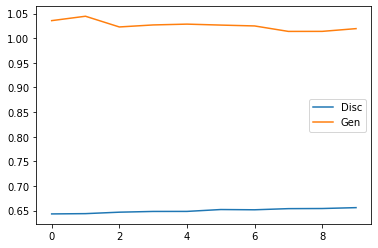

In [ ]:
plt.plot(d_losses,label="Disc")
plt.plot(g_losses,label="Gen")
plt.legend()
plt.show()

In [ ]:
!zip -r /content/images.zip /content/images
from google.colab import files
files.download('images.zip')

  adding: content/images/ (stored 0%)
  adding: content/images/gan_output_epoch_10.png (deflated 6%)
  adding: content/images/gan_output_epoch_5.png (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>